# CIS 6115 Mini Project 4: Humpback Whale Identificaiton with CNNs

Use this notebook as the starting point for the Project activities. We will  be working with a subset of the images from the [Kaggle Humpback Whale Identification challenge](https://www.kaggle.com/c/humpback-whale-identification).


## Watch the following videos
- [Mini Project 4 Walkthough Video by Tom](https://youtu.be/Tc4ILHRrHEc)





In [0]:
# Display video link below
from IPython.lib.display import YouTubeVideo
YouTubeVideo('Tc4ILHRrHEc')

# Section 0: Set up libraries and training data

=== *You must run this section to set up things for any of the sections below * ===
### Setting up Python tools



We'll use three libraries for this tutorial: 
- [pandas](http://pandas.pydata.org/) : dataframes for spreadsheet-like data analysis, reading CSV files, time series
- [numpy](http://www.numpy.org/) : for multidimensional data and linear algebra tools
- [matplotlib](http://matplotlib.org/) : Simple plotting and graphing
- [seaborn](http://stanford.edu/~mwaskom/software/seaborn/) : more advanced graphing
-  [scikit-learn](https://scikit-learn.org/stable/) : provides many machine learning algorithms and tools to training and test.




In [1]:
# First, we'll import pandas and numpy, two data processing libraries
import pandas as pd
import numpy as np

# We'll also import seaborn and matplot, twp Python graphing libraries
import seaborn as sns
import matplotlib.pyplot as plt
# Import the needed sklearn libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# The Keras library provides support for neural networks and deep learning
# Use the updated Keras library from Tensorflow -- provides support for neural networks and deep learning
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
#from keras.utils import np_utils

# We will turn off some warns in this notebook to make it easier to read for new students
import warnings
warnings.filterwarnings('ignore')

print ("Libraries imported")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Libraries imported


## Read  the data from Github

If you are using Google's Colab, you need to copy the images from GitHub. This may take a couple minutes.

Check the left panel and you should see a folder called CIS6115-whales created under the Files tab.

# Using a Reduced Dataset
The original image data from the challenged include 41,000+ images of over 600 whales and took up nearly 7 GB of storage. The time required to copy this data into Colab was unmanageable and the training times for this main images often went beyound the 12 hour runtime limit for Colab notebooks.

So, the data we are using is only 10 images of the 200 most common whales.



In [2]:
!rm -rf /content/CIS6115-whales
!git clone https://github.com/CIS3115-Machine-Learning-Scholastica/HumpbackWhaleImages CIS6115-whales


Cloning into 'CIS6115-whales'...
remote: Enumerating objects: 4164, done.
remote: Total 4164 (delta 0), reused 0 (delta 0), pack-reused 4164
Receiving objects: 100% (4164/4164), 642.48 MiB | 40.41 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Checking out files: 100% (3664/3664), done.


## Display sample whale images

Here the images of two of the whales in the database. 

You can also look in the CIS6115-whale folder on the right side of the notebook to see full-sized images

Images of Whale w_0135f5f
Images of Whale w_15805cd


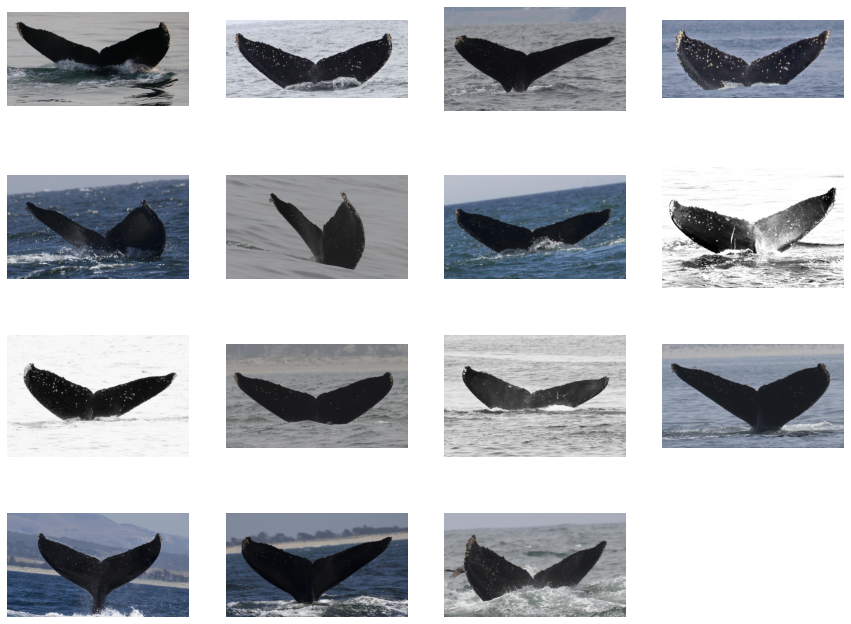

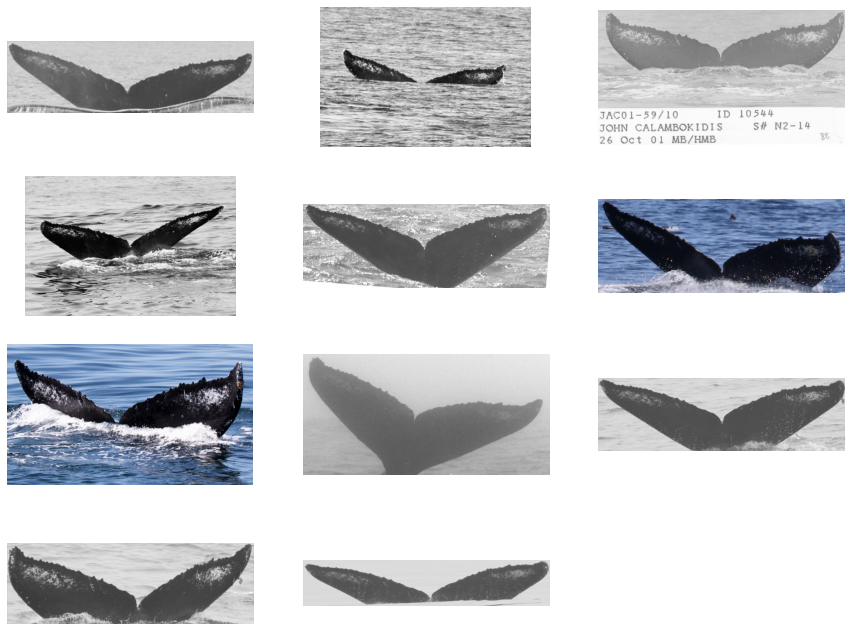

In [3]:
from glob import glob
from PIL import Image

def plot_images(imgs, rows=5):
    # Set figure to 13 inches x 8 inches
    figure = plt.figure(figsize=(15, 15))
    cols = len(imgs) // rows + 1
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        plt.imshow(imgs[i])

def plot_images_for_filenames(filenames, rows=5):
    imgs = [plt.imread(f'{filename}') for filename in filenames]
    return plot_images(imgs, rows)
    
whale_images = glob("CIS6115-whales/train_top_200_cat/w_0135f5f/*.jpg")
print ("Images of Whale w_0135f5f")
plot_images_for_filenames(whale_images)   

whale_images = glob("CIS6115-whales/train_top_200_cat/w_15805cd/*.jpg")
print ("Images of Whale w_15805cd")
plot_images_for_filenames(whale_images) 


## Set up callbacks for training

*You do not need to change this code.*

### Learning Rate

The Learning Rate determines how much the weights in a neural network are changed during training. When the Learning Rate is set correctly, the network weights are changed a little bit for each input--in our case for each image. These slight adjustments from each image allow the network to learn all the weights over a long time.

For more on the Learning Rate, see [Understanding Learning Rates and How It Improves Performance in Deep Learning](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10)

###EarlyStopping: 
[EarlyStopping documenation on Keras](https://keras.io/callbacks/#earlystopping)

### ModelCheckpoint:
[ModelCheckpoint documentation on Keras](https://keras.io/callbacks/#modelcheckpoint)

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=7, 
                                            verbose=2, 
                                            factor=0.5,                                            
                                            min_lr=0.000001)

early_stops = EarlyStopping(monitor='loss', 
                            min_delta=0, 
                            patience=10, 
                            verbose=2, 
                            mode='auto')

checkpointer = ModelCheckpoint(filepath = 'CIS6115_MINIPROJECT4.{epoch:02d}-{accuracy:.6f}.hdf5',
                               verbose=2,
                               save_best_only=True, 
                               save_weights_only = True)


## Set up the folders for the images 

In [5]:
# Read data from the actual Kaggle download files stored in a raw file in GitHub
colab_folder = '/content/CIS6115-whales/'
local_folder = '..\\input\\2019_whale_all\\'

data_folder = colab_folder
# Uncomment the next line to switch from using the github files to the local files for a submission
#data_folder = local_folder

train_folder =  data_folder + 'train_top_200_cat'
validate_folder = data_folder + 'validate_top_200_cat'

print ("Reading training images from: " ,train_folder)
print ("Reading validation images from: " ,validate_folder)


Reading training images from:  /content/CIS6115-whales/train_top_200_cat
Reading validation images from:  /content/CIS6115-whales/validate_top_200_cat


## ImageDataGenerator

Keras uses [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) to do conversions and adjustments to images.

**Image augmentation:** You can easily add image augmentation to the ImageDataGenerators. Options include random scaling, shifting, or rotating of images. One common option is to allow random horizonal flipping of images.

**test_datagen :**For testing we only scale the data. RGB images have pixels from 0 to 255, so we scale each pixel by 1/255 so the data is between 0 and 1.

**train_datagen :** This is used for training. You can decide if you want to rotate, shift, shear, zoom or flip the image.

- For more information check out [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) from the Keras blog. 
- You might  also want to read [Image Augmentation for Deep Learning With Keras](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) by Jason Brownlee



In [0]:
# Set up your image generators here

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255
        # featurewise_center=False,  # set input mean to 0 over the dataset
        # samplewise_center=False,  # set each sample mean to 0
        # featurewise_std_normalization=False,  # divide inputs by std of the dataset
        # samplewise_std_normalization=False,  # divide each input by its std
        # zca_whitening=False,  # apply ZCA whitening
        # rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        # zoom_range = 0.20, # Randomly zoom image 
        # width_shift_range=0.10,  # randomly shift images horizontally (fraction of total width)
        # height_shift_range=0.10,  # randomly shift images vertically (fraction of total height)
        # horizontal_flip=True,  # randomly flip images
        # vertical_flip=False,    
        # add other options here
        )

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(
        rescale=1./255
        )

## Reading Images with flow_from_directory()

**Image resizing: **Some prebuilt CNNs expect images to be a certain size. The flow_from_directory() method has an option to resize the images as they are read in from the image files. Currently images are resized to 256x256 pixels, through the top results from this challenge used images at 512x512 pixels.

Keras has a method called  [flow_from_directory()](https://keras.io/preprocessing/image/#flow_from_directory) defined for an ImageDataGenerator.



In [7]:
# Set up your training generators for flow_from_directory here

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_folder,  # this is the target directory
        target_size=(256, 256),  # all images will be resized to 150x150
        batch_size=16,
        class_mode='categorical')  

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validate_folder,
        target_size=(256, 256),
        batch_size=16,
        class_mode='categorical')



Found 2743 images belonging to 200 classes.
Found 919 images belonging to 200 classes.


# Section 1: Set up and train a deep CNN




## Set up a deep CNN

This problem works with 256x256 images and will require a deep network--that means many layers.

### Share your code: 

You are encouraged to share your network configurations in the course discussion area. You can post your python/keras code there to show how you to set up these different networks.

## Option 1: Define your own Deep Network Archtecture

You are free to try your own CNN architecture for this challenge. The code below starts with the basic artchitecture defined on page 461 of the textbook:

>Let’s go through this model:
- The first layer uses 64 fairly large filters (7 × 7) but no stride because the input
images are not very large. It also sets input_shape=[28, 28, 1], because the
images are 28 × 28 pixels, with a single color channel (i.e., grayscale).
- Next we have a max pooling layer which uses a pool size of 2, so it divides each spatial dimension by a factor of 2.
- Then we repeat the same structure twice: two convolutional layers followed by a max pooling layer. For larger images, we could repeat this structure several more times (the number of repetitions is a hyperparameter you can tune).
- Note that the number of filters grows as we climb up the CNN toward the output
layer (it is initially 64, then 128, then 256): it makes sense for it to grow, since the number of low-level features is often fairly low (e.g., small circles, horizontal lines), but there are many different ways to combine them into higher-level features. It is a common practice to double the number of filters after each pooling layer: since a pooling layer divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps in the next layer without fear of exploding the number of parameters, memory usage, or computational load.
- Next is the fully connected network, composed of two hidden dense layers and a
dense output layer. Note that we must flatten its inputs, since a dense network
expects a 1D array of features for each instance. We also add two dropout layers, with a dropout rate of 50% each, to reduce overfitting.

You can start with this structure of build your own if you want. You can also duplicate one of the CNN structures described in the textbook.



In [8]:
# Set up the Neural Network
input_Size = (256,256,3)   
output_Size = 200

# Here the sample from page 461 of the textbook
model = Sequential([
  Conv2D(64, 7, activation="relu", padding="same", input_shape=input_Size),
  MaxPooling2D(2),
  Conv2D(128, 3, activation="relu", padding="same"),
  Conv2D(128, 3, activation="relu", padding="same"),
  MaxPooling2D(2),
  Conv2D(256, 3, activation="relu", padding="same"),
  Conv2D(256, 3, activation="relu", padding="same"),
  MaxPooling2D(2),
  Flatten(),
  Dense(128, activation="relu"),
  Dropout(0.5),
  Dense(64, activation="relu"),
  Dropout(0.5),
  Dense(output_Size, activation="softmax")
])

print ("Neural Network Model created")
model.summary()

# Compile neural network model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Neural Network Model created
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)          

## Option 2: Load in prebuilt CNN Architecture

There are a number of more complext [CNN artchitectures that you can load in from Keras](https://keras.io/api/applications/). You can load these in with pretrained weights if you want.  These are defined starting on page 463 of the textbook, but the older ones are not available.

 Consider one of the following [architectures summarized here](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5).  Some of these layers have non-sequential layers. So far in Keras we have been using Sequential networks, where each layer is automatically connected to the previous layer. You may need to use Keras's Functional layers here where you specify how each layer is connected. See [How to Use the Keras Functional API for Deep Learning](https://machinelearningmastery.com/keras-functional-api-deep-learning/)*--we will be covering this more in the coming units.*

- VGG16: developed in [2014](https://arxiv.org/abs/1409.1556) and 2015
 - [VGG16 – Convolutional Network for Classification and Detection](https://neurohive.io/en/popular-networks/vgg16/)
 
- RESnet: developed in [2015](https://arxiv.org/abs/1512.03385)
 - [An Overview of ResNet and its Variants](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)

- Google Inception or GoogLeNet: developed from 2014-2016
 - [A Simple Guide to the Versions of the Inception Network](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202)

- Google Inception Resnet combination
 - [ Improving Inception and Image Classification in TensorFlow](https://ai.googleblog.com/2016/08/improving-inception-and-image.html)
 - [ Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning](https://arxiv.org/pdf/1602.07261.pdf)

Prebuilt CNN architectures can be loaded with pretrained weights from the [ImageNet image dataset](http://www.image-net.org/). 

In [0]:
# Set up the Neural Network
input_Size = (256,256,3)   
output_Size = 200

# ==== VGG === works with 224x224 size images
# ==== uncomment one of these lines to use the VGG16 model
#pretrained_model = tf.keras.applications.VGG16(weights=None, include_top=False ,input_shape=input_Size)         # Using random initial weights
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=input_Size)   # Using pretrained weights from Imagenet

# ==== DenseNet201 === 
# ==== uncomment one of these lines to use the DenseNet201 model
#pretrained_model = tf.keras.applications.DenseNet201(weights=None, include_top=False ,input_shape=input_Size)        # Using random initial weights
#pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=input_Size)  # Using pretrained weights from Imagenet

# ==== Xception === 
# ==== uncomment one of these lines to use the Xception model
# by default Xception expects images of size 299x299 pixels
#pretrained_model = tf.keras.applications.Xception(weights=None, include_top=False ,input_shape=input_Size)            # Using random initial weights
pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=input_Size)      # Using pretrained weights from Imagenet

# Set the model so that all the weights are trainable with the new whale images
pretrained_model.trainable = True      # False = transfer learning, True = fine-tuning

# Here the sample from page 461 of the textbook
model = Sequential([
    pretrained_model,                                 # Include layers in pretrained model from above
    GlobalAveragePooling2D(),
    #Dense(1024, activation="relu"),     # Can add optional additional layers here
    #Dense(200, activation="relu"),      # Can add optional additional layers here
    Dense(output_Size, activation='softmax')
])

# ==== Optimizer === We will study these options in a future unit. For not, just leave as RMSprop
# Some sample weight optimizer settings
#RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
optimizer_RMSprop = RMSprop(lr=0.00001, epsilon=1e-08)
#optimizer_Adam = Adam(learning_rate=0.001) # default learning rate
optimizer_Adam = Adam(learning_rate=0.0001)

model.compile(
#    optimizer=optimizer_Adam,
    optimizer=optimizer_RMSprop,
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

print ("=== Pretrained Model =========================================================================")
pretrained_model.summary()   # print layers in pretrained model
print ("=== Final Model =========================================================================")
model.summary()              # print final model

=== Pretrained Model =========================================================================
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]         

## Train the Neural Network

**Epochs -** The main thing you want to consider changing here is the number of epochs. The initial data uses only 20 epochs, but you will probably get better results if you train for longer... say 100 epochs.
 
- train_generator: The image generator above to use. Can rotate or shift images if desired
- steps_per_epoch=150: Number of images to process per epoch, will random choose from the whale images. There are over 2,700 whale images in our data set.
- **epochs=100:** Number of epochs. Should be large enough to train on every image mulitple times
- learning_rate_reduction: Reduce the learning rate if loss does not keep dropping
- early_stops: Stop if loss does not keep dropping
- validation_generator: The image generator to use for validation, not rotations or shifting
- validation_steps: Number of random images to use during validation. There are over 900 whale images in our validation data set.
 





In [11]:
# Train your network here

# This sample does not train using enough images to get any real results. 
# These parameters will train quickly, by ineffectively
history = model.fit(
        train_generator,
        steps_per_epoch=150,                    # Number of images to process per epoch 
        epochs=20,                             # Number of epochs
        callbacks=[learning_rate_reduction, early_stops],
        validation_data=validation_generator,
        validation_steps=20 )                  # Number of images to test during validation


Epoch 1/20
150/150 [==============================] - 36s 241ms/step - loss: 5.3225 - accuracy: 4.1824e-04 - val_loss: 5.2957 - val_accuracy: 0.0063 - lr: 0.0010
Epoch 2/20
150/150 [==============================] - 35s 231ms/step - loss: 5.2987 - accuracy: 0.0029 - val_loss: 5.2916 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/20
150/150 [==============================] - 34s 229ms/step - loss: 5.2983 - accuracy: 0.0046 - val_loss: 5.2881 - val_accuracy: 0.0219 - lr: 0.0010
Epoch 4/20
150/150 [==============================] - 34s 230ms/step - loss: 5.2977 - accuracy: 0.0025 - val_loss: 5.2874 - val_accuracy: 0.0031 - lr: 0.0010
Epoch 5/20
150/150 [==============================] - 35s 231ms/step - loss: 5.2973 - accuracy: 0.0042 - val_loss: 5.2856 - val_accuracy: 0.0031 - lr: 0.0010
Epoch 6/20
150/150 [==============================] - 35s 231ms/step - loss: 5.2966 - accuracy: 0.0054 - val_loss: 5.2820 - val_accuracy: 0.0031 - lr: 0.0010
Epoch 7/20
150/150 [========================

## Plot the Training History

We store the performance during training in a variable named 'history'. The x-axis is the training time or number of epochs.

- Accuracy: Accuracy of the predictions; hopefully this is increasing to near 1.0
- Loss: How close the output is to the desired output; this should decrease to near 0.0

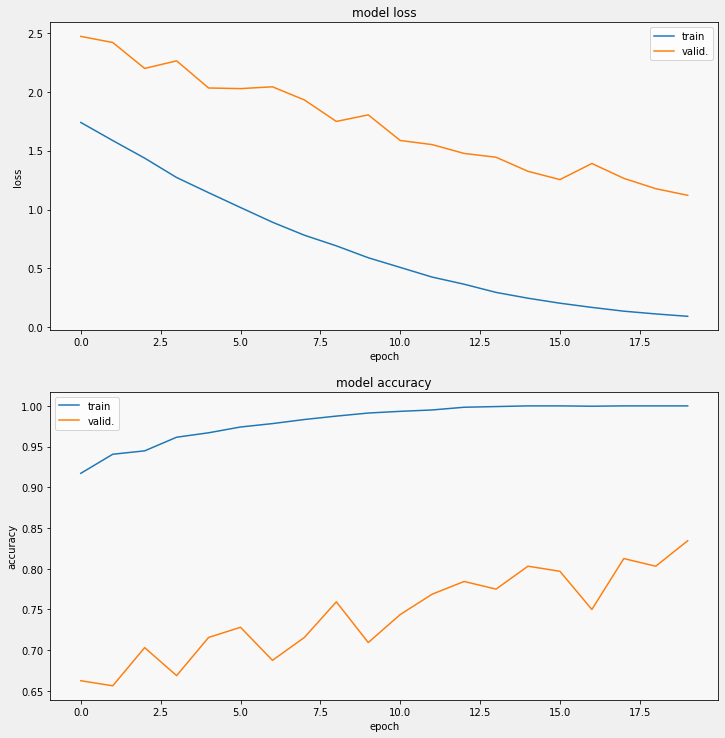

In [0]:


# We will display the loss and the accuracy of the model for each epoch
# NOTE: this is a little fancy display than is shown in the textbook
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# We store the performance during training in a variable named 'history'. The x-axis is the training time or number of epochs.
#    Accuracy: Accuracy of the predictions; hopefully this is increasing to near 1.0
#    Loss: How close the output is to the desired output; this should decrease to near 0.0
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)


# Writeup: Try out three different CNN architectures or options

## Writeup 1: Whale Challenge Summary
Read about the  the [Kaggle Humpback Whale Identification challenge](https://www.kaggle.com/c/humpback-whale-identification).

Write a short summary of the challenge in the (https://docs.google.com/document/d/18w63LifLMnjBl0hMLsKPXO5oO92aG5H6ETK0tJP6IHw/edit?usp=sharing).

- What is the goal of the challenge?
- Why do people want to identify Humpback Whales from their tails?
- What images are provided?

*Make sure you put this in your own words--do not just cut/paste from Kaggle*

## Writeup 2: Try three differnt CNN Architectures or options

You must train three different CNN models and compare the results. You can use a different CNN architecture for each model or simply change one of the configurations. These include:
- Adding image augmentations using the `ImageDataGenerator`
- Changing the image size using the flow_from_directory() method
- Using the pretrained weights or not when you load in a prebult model
- Adding aditional dense layers to a prebuilt model
- Trying out different CNN architecutes

For each of your three models describe your network model including the layers you used and whatever options you chose to change.

Make sure you include 
- How many total paremeters are in your model? (This is given at the end of the network summary)
- How long you trained your model (number of epochs)
- What your final accuracy was (both the training and validation accuracy)

*Feel free to post your results to the course discussion area.*

# Writeup 3: Summary 

Write a paragraph summarizing your results and analyze why you think they turned out the way they did.